# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [5]:
# using SQLite Table to read data.
con = sqlite3.connect('/content/drive/My Drive/amazon/database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [7]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [8]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [9]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [10]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [12]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [13]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [14]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [16]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [17]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [18]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [19]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [21]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it, it would poison them. Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut, facts though say otherwise. Until the late 70 is it was poisonous until they figured out a way to fix that. I still like it but it could be better.


In [22]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [23]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Great ingredients although chicken should have been 1st rather than chicken broth the only thing I do not think belongs in it is Canola oil Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it it would poison them Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut facts though say otherwise Until the late 70 is it was poisonous until they figured out a way to fix that I still like it but it could be better 


In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [25]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 364171/364171 [02:05<00:00, 2906.05it/s]


In [26]:
preprocessed_reviews[364000]

'pumpkin pie syrup absolutely delicious made lattes taste amazing like liquid pumpkin pie purchase product'

### [4] Featurization

##### [4.1] BAG OF WORDS

In [ ]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

##### [4.2] Bi-Grams and n-Grams.

In [ ]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

##### [4.3] TF-IDF

In [ ]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

##### [4.4] Word2Vec

In [ ]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

##### [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

In [ ]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

# [5] Assignment 7: SVM

# Applying SVM

## [5.1] Linear SVM

In [28]:
#obtaining the cleaned_text from the preprocessed_reviews  for the given dataset.
final['cleaned_text']=preprocessed_reviews
#Applying the time based splitting for the sample 15k datapts.
final.sort_values(by='Time')
final1 = final.sample(n = 100000)

Y = final1['Score'].values
X = final1['cleaned_text'].values
print(X.shape,type(X))
print(Y.shape,type(Y))

(100000,) <class 'numpy.ndarray'>
(100000,) <class 'numpy.ndarray'>


In [0]:
#importing library.
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer


In [30]:
# performing training,CV & testing for performing splitting of the dataset.
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,random_state=12,shuffle=False)
X_train,X_cv,Y_train,Y_cv=train_test_split(X,Y,test_size=0.2,random_state=12,shuffle=False)
print("*"*10)
print("After splitting the data")
print(X_train.shape,Y_train.shape)
print(X_cv.shape,Y_cv.shape)
print(X_test.shape,Y_test.shape)

**********
After splitting the data
(80000,) (80000,)
(20000,) (20000,)
(20000,) (20000,)


In [0]:
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt 

### [5.1.1] Applying Linear SVM on BOW,<font color='red'> SET 1</font>

In [32]:
vectorizer=CountVectorizer()
vectorizer=vectorizer.fit(X_train)

X_train_bow=vectorizer.transform(X_train)
X_cv_bow=vectorizer.transform(X_cv)
X_test_bow=vectorizer.transform(X_test)

print("After transforming the data")
print(X_train_bow.shape,Y_train.shape)
print(X_cv_bow.shape,Y_cv.shape)
print(X_test_bow.shape,Y_test.shape)

After transforming the data
(80000, 54543) (80000,)
(20000, 54543) (20000,)
(20000, 54543) (20000,)


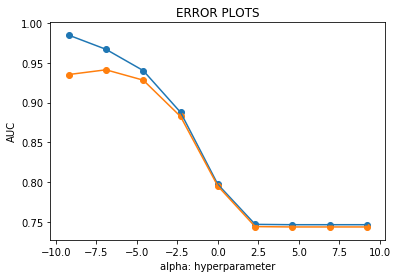

In [33]:
import math
train_auc=[]
cv_auc=[]

alpha=[10**-4,10**-3,10**-2,10**-1,10**0,10**1,10**2,10**3,10**4]
logalpha=[]
for i in alpha:
    clf=SGDClassifier(alpha=i,class_weight="balanced")
    clf.fit(X_train_bow,Y_train)
    ccv=CalibratedClassifierCV(clf,cv="prefit")
    ccv.fit(X_cv_bow,Y_cv)
    Y_train_pred =  ccv.predict_proba(X_train_bow)[:,1]
    Y_cv_pred =  ccv.predict_proba(X_cv_bow)[:,1]
    
    train_auc.append(roc_auc_score(Y_train,Y_train_pred))
    cv_auc.append(roc_auc_score(Y_cv, Y_cv_pred))
    
    logalpha.append(math.log(i))
    
plt.plot(logalpha, train_auc, label='Train AUC')
plt.scatter(logalpha, train_auc, label='Train AUC')
plt.plot(logalpha, cv_auc, label='CV AUC')
plt.scatter(logalpha, cv_auc, label='CV AUC')

plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

******************************************************************************************************************************************************
Optimal number alpha:  0.001


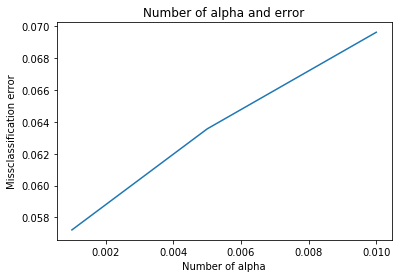

In [34]:
cv_score = []
alpha=[0.001,0.005,0.01]
for k in alpha:
    cvs = SGDClassifier(alpha=k,class_weight="balanced")
    scores = cross_val_score(cvs, X_train_bow, Y_train, cv=10, scoring='roc_auc')
    cv_score.append(scores.mean())

print("*"*150)
# Miss classification error
MSE = [1-x for x in cv_score]
optimal_alpha1 = alpha[MSE.index(min(MSE))]
print("Optimal number alpha: ", optimal_alpha1)

plt.plot(alpha, MSE)
plt.title("Number of alpha and error")
plt.xlabel("Number of alpha")
plt.ylabel("Missclassification error")
plt.show()

In [0]:
model = SGDClassifier(alpha=optimal_alpha1,class_weight="balanced")
model.fit(X_train_bow, Y_train)
optimal_model=CalibratedClassifierCV(model,cv="prefit")
optimal_model.fit(X_cv_bow,Y_cv)
prediction = optimal_model.predict(X_test_bow)

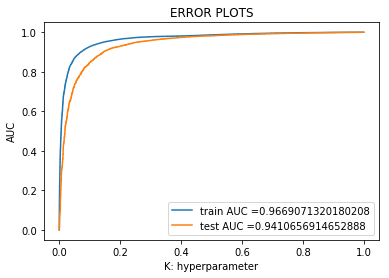

In [36]:
train_fpr, train_tpr, thresholds = roc_curve(Y_train, optimal_model.predict_proba(X_train_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, optimal_model.predict_proba(X_test_bow)[:,1])
AUC1=str(auc(test_fpr, test_tpr))
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

confusion_matrix for train_data


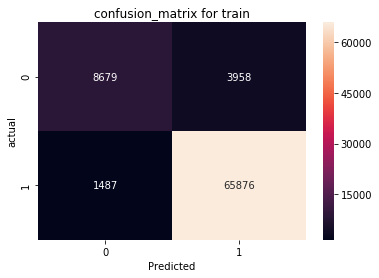

********************
confusion_matrix for test_data.


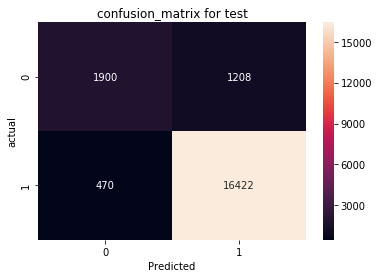

In [37]:
print("confusion_matrix for train_data")
conf_matrix = confusion_matrix(Y_train,optimal_model.predict(X_train_bow))
class_label =[0,1]
df_conf_matrix = pd.DataFrame(conf_matrix,index=class_label,columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("confusion_matrix for train")
plt.xlabel("Predicted")
plt.ylabel('actual')
plt.show()
print("*"*20)

print("confusion_matrix for test_data.")
conf_matrix = confusion_matrix(Y_test,optimal_model.predict(X_test_bow))
class_label =[0,1]
df_conf_matrix = pd.DataFrame(conf_matrix,index=class_label,columns=class_label)
sns.heatmap(df_conf_matrix,annot=True,fmt='d')
plt.title("confusion_matrix for test")
plt.xlabel("Predicted")
plt.ylabel('actual')
plt.show()

In [38]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, prediction))

              precision    recall  f1-score   support

           0       0.80      0.61      0.69      3108
           1       0.93      0.97      0.95     16892

    accuracy                           0.92     20000
   macro avg       0.87      0.79      0.82     20000
weighted avg       0.91      0.92      0.91     20000



### [5.1.2] Applying Linear SVM on TFIDF,<font color='red'> SET 2</font>

In [0]:
# Please write all the code with proper documentation
Tfidf_vect = TfidfVectorizer(ngram_range=(1,2),min_df = 10)
Tfidf_vect.fit(X_train)

Tfidf_train = Tfidf_vect.transform(X_train)
Tfidf_cv = Tfidf_vect.transform(X_cv)
Tfidf_test = Tfidf_vect.transform(X_test)

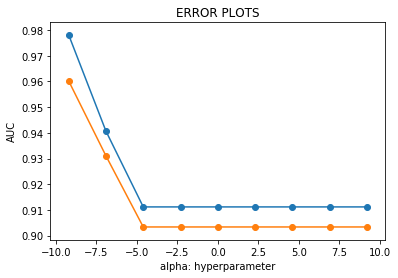

In [40]:
train_auc=[]
cv_auc=[]
import math
alpha=[10**-4,10**-3,10**-2,10**-1,10**0,10**1,10**2,10**3,10**4]
logalpha=[]
for i in alpha:
    clf=SGDClassifier(alpha=i,class_weight="balanced")
    clf.fit(Tfidf_train,Y_train)
    ccv=CalibratedClassifierCV(clf,cv="prefit")
    ccv.fit(Tfidf_cv,Y_cv)
    Y_train_pred =  ccv.predict_proba(Tfidf_train)[:,1]
    Y_cv_pred =  ccv.predict_proba(Tfidf_cv)[:,1]
    
    train_auc.append(roc_auc_score(Y_train,Y_train_pred))
    cv_auc.append(roc_auc_score(Y_cv, Y_cv_pred))
    
    logalpha.append(math.log(i))
    
plt.plot(logalpha, train_auc, label='Train AUC')
plt.scatter(logalpha, train_auc, label='Train AUC')
plt.plot(logalpha, cv_auc, label='CV AUC')
plt.scatter(logalpha, cv_auc, label='CV AUC')

plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

******************************************************************************************************************************************************
Optimal number alpha:  0.001


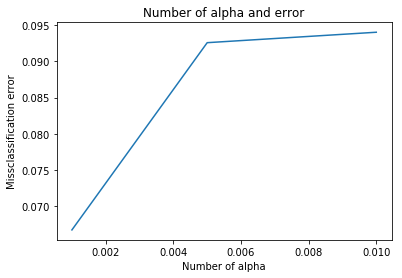

In [41]:
cv_score = []
alpha=[0.001,0.005,0.01]
for k in alpha:
    cvs = SGDClassifier(alpha=k,class_weight="balanced")
    scores = cross_val_score(cvs, Tfidf_train, Y_train, cv=10, scoring='roc_auc')
    cv_score.append(scores.mean())

print("*"*150)
# Miss classification error
MSE = [1-x for x in cv_score]
optimal_alpha2 = alpha[MSE.index(min(MSE))]
print("Optimal number alpha: ", optimal_alpha2)

plt.plot(alpha, MSE)
plt.title("Number of alpha and error")
plt.xlabel("Number of alpha")
plt.ylabel("Missclassification error")
plt.show()

In [0]:
model = SGDClassifier(alpha=optimal_alpha2,class_weight="balanced")
model.fit(Tfidf_train, Y_train)
optimal_model=CalibratedClassifierCV(model,cv="prefit")

optimal_model.fit(Tfidf_cv,Y_cv)
prediction = optimal_model.predict(Tfidf_test)

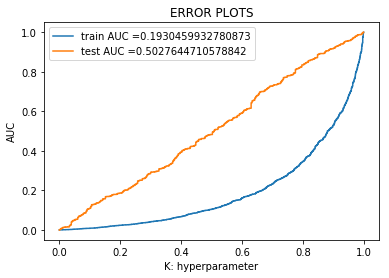

In [130]:
train_fpr, train_tpr, thresholds = roc_curve(Y_train, optimal_model.predict_proba(Tfidf_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, optimal_model.predict_proba(Tfidf_test)[:,1])
AUC2=str(auc(test_fpr, test_tpr))
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

confusion_matrix for train_data


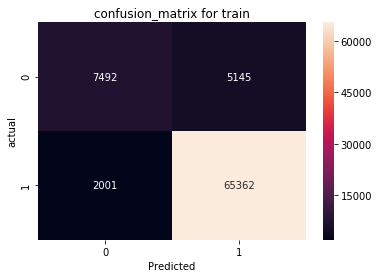

********************
confusion_matrix for test_data.


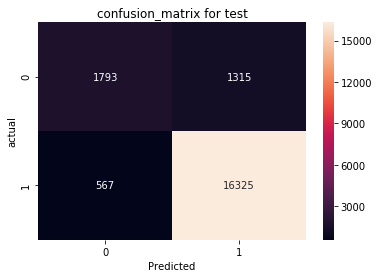

In [44]:
print("confusion_matrix for train_data")
conf_matrix = confusion_matrix(Y_train,optimal_model.predict(Tfidf_train))
class_label =[0,1]
df_conf_matrix = pd.DataFrame(conf_matrix,index=class_label,columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("confusion_matrix for train")
plt.xlabel("Predicted")
plt.ylabel('actual')
plt.show()
print("*"*20)

print("confusion_matrix for test_data.")
conf_matrix = confusion_matrix(Y_test,optimal_model.predict(Tfidf_test))
class_label =[0,1]
df_conf_matrix = pd.DataFrame(conf_matrix,index=class_label,columns=class_label)
sns.heatmap(df_conf_matrix,annot=True,fmt='d')
plt.title("confusion_matrix for test")
plt.xlabel("Predicted")
plt.ylabel('actual')
plt.show()

In [45]:
from sklearn.metrics import classification_report
print(classification_report(Y_test,prediction))

              precision    recall  f1-score   support

           0       0.76      0.58      0.66      3108
           1       0.93      0.97      0.95     16892

    accuracy                           0.91     20000
   macro avg       0.84      0.77      0.80     20000
weighted avg       0.90      0.91      0.90     20000



### [5.1.3]  Applying Linear SVM on AVG W2V,<font color='red'> SET 3</font>

In [46]:
i=0
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())

# this line of code trains your w2v model on the give list of sentances
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)

w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  17172
sample words  ['wife', 'introduced', 'stuff', 'outstanding', 'replacement', 'soy', 'sauce', 'like', 'love', 'whole', 'lot', 'healthier', 'decided', 'switch', 'cat', 'food', 'kinds', 'problems', 'excessive', 'throwing', 'urinary', 'tract', 'issues', 'significant', 'weight', 'loss', 'vet', 'could', 'not', 'explain', 'switched', 'kirkland', 'dry', 'friskies', 'turkey', 'pate', 'canned', 'wellness', 'chicken', 'formula', 'almost', 'overnight', 'miracle', 'put', 'least', 'pound', 'weeks', 'eats', 'entire', 'oz']


In [47]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sentance_train: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
sent_vectors_train = np.array(sent_vectors_train)
print(sent_vectors_train.shape)
print(sent_vectors_train[0])

(80000, 50)
[-0.72895796  0.16920557 -0.76542708  0.54709428  0.0357691   0.30088818
 -0.92052689 -0.5483601  -0.38738159  0.25678294  0.43666448  1.30967213
 -0.79647353 -0.37033545 -0.83785294 -0.16758421  0.23277885 -0.29240216
 -1.15768354 -0.26878664 -0.65442539 -0.0803414   0.05307716  0.2621974
 -0.15249893 -0.17856658 -0.44035969 -1.2742621   0.49469698 -0.22183558
  0.63734367  0.18332762  1.02482724 -0.07546564 -0.11824686  0.26141651
  0.50010146 -0.18155246  0.0497736   0.44514756  0.69809307  1.32786009
  0.89051427 -0.93565343 -0.02208304 -0.44143326 -0.53023665  0.31217223
 -0.56788194 -0.0198964 ]


In [48]:
i=0
list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sentance_cv: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
sent_vectors_cv = np.array(sent_vectors_cv)
print(sent_vectors_cv.shape)
print(sent_vectors_cv[0])

(20000, 50)
[ 0.00556981 -0.20335597  0.19663421  0.39077077  0.06238451 -0.12170836
 -0.78532939  0.1610322   0.12904906 -0.26445919  0.06997045 -0.3026135
 -0.20870252 -0.34924513 -0.23446892  0.10752132  0.69040229 -0.39841853
 -0.1428435   0.02663443  0.09293351 -0.34985936 -0.00810114 -0.02721511
  0.56488518  0.23598483 -0.04585091 -0.90202367  0.27534022 -0.2193387
  0.71507375  0.16025317  0.06196505 -0.69286622 -0.11583458  0.00250676
  0.19276895  0.55125661  0.10008321  0.25094543  0.40182361  0.58023874
  0.43285042 -0.04850915  0.60021707 -0.42786435  0.1974797  -0.4849188
 -0.07278424 -0.13658143]


In [49]:
i=0
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sentance_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
sent_vectors_test = np.array(sent_vectors_test)
print(sent_vectors_test.shape)
print(sent_vectors_test[0])

(20000, 50)
[ 0.00556981 -0.20335597  0.19663421  0.39077077  0.06238451 -0.12170836
 -0.78532939  0.1610322   0.12904906 -0.26445919  0.06997045 -0.3026135
 -0.20870252 -0.34924513 -0.23446892  0.10752132  0.69040229 -0.39841853
 -0.1428435   0.02663443  0.09293351 -0.34985936 -0.00810114 -0.02721511
  0.56488518  0.23598483 -0.04585091 -0.90202367  0.27534022 -0.2193387
  0.71507375  0.16025317  0.06196505 -0.69286622 -0.11583458  0.00250676
  0.19276895  0.55125661  0.10008321  0.25094543  0.40182361  0.58023874
  0.43285042 -0.04850915  0.60021707 -0.42786435  0.1974797  -0.4849188
 -0.07278424 -0.13658143]


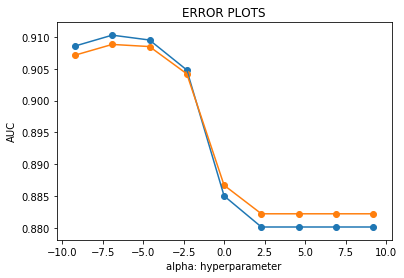

In [50]:

train_auc=[]
cv_auc=[]
import math
alpha=[10**-4,10**-3,10**-2,10**-1,10**0,10**1,10**2,10**3,10**4]
logalpha=[]
for i in alpha:
    clf=SGDClassifier(alpha=i,class_weight="balanced")
    clf.fit(sent_vectors_train,Y_train)
    ccv=CalibratedClassifierCV(clf,cv="prefit")
    ccv.fit(sent_vectors_cv,Y_cv)
    Y_train_pred =  ccv.predict_proba(sent_vectors_train)[:,1]
    Y_cv_pred =  ccv.predict_proba(sent_vectors_cv)[:,1]
    
    train_auc.append(roc_auc_score(Y_train,Y_train_pred))
    cv_auc.append(roc_auc_score(Y_cv, Y_cv_pred))
    
    logalpha.append(math.log(i))
    
plt.plot(logalpha, train_auc, label='Train AUC')
plt.scatter(logalpha, train_auc, label='Train AUC')
plt.plot(logalpha, cv_auc, label='CV AUC')
plt.scatter(logalpha, cv_auc, label='CV AUC')

plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

******************************************************************************************************************************************************
Optimal number alpha:  0.001


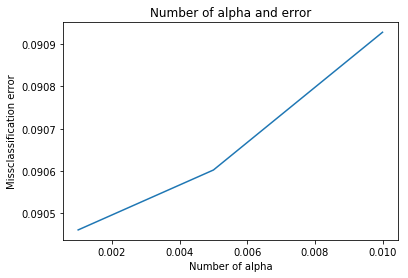

In [51]:
cv_score = []
alpha=[0.001,0.005,0.01]
for k in alpha:
    cvs = SGDClassifier(alpha=k,class_weight="balanced")
    scores = cross_val_score(cvs, sent_vectors_train, Y_train, cv=10, scoring='roc_auc')
    cv_score.append(scores.mean())

print("*"*150)
# Miss classification error
MSE = [1-x for x in cv_score]
optimal_alpha3 = alpha[MSE.index(min(MSE))]
print("Optimal number alpha: ", optimal_alpha3)

plt.plot(alpha, MSE)
plt.title("Number of alpha and error")
plt.xlabel("Number of alpha")
plt.ylabel("Missclassification error")
plt.show()

In [0]:
model = SGDClassifier(alpha=optimal_alpha3,class_weight="balanced")
model.fit(sent_vectors_train, Y_train)
optimal_model=CalibratedClassifierCV(model,cv="prefit")
optimal_model.fit(sent_vectors_cv,Y_cv)
prediction = optimal_model.predict(sent_vectors_test)

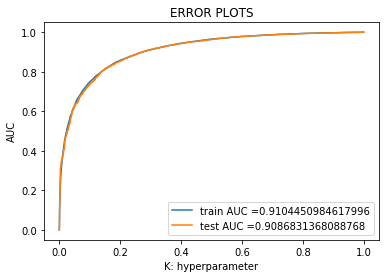

In [53]:
train_fpr, train_tpr, thresholds = roc_curve(Y_train, optimal_model.predict_proba(sent_vectors_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, optimal_model.predict_proba(sent_vectors_test)[:,1])
AUC3=str(auc(test_fpr, test_tpr))
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show() 

confusion_matrix for train_data


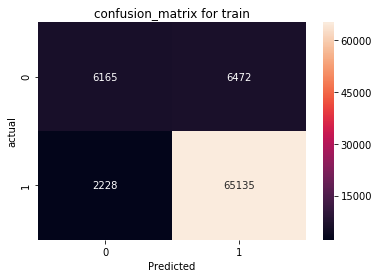

********************
confusion_matrix for test_data.


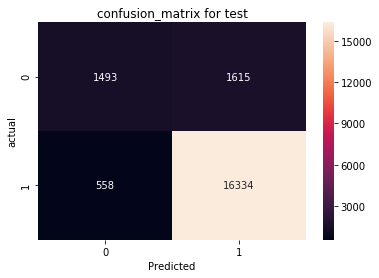

In [54]:
print("confusion_matrix for train_data")
conf_matrix = confusion_matrix(Y_train,optimal_model.predict(sent_vectors_train))
class_label =[0,1]
df_conf_matrix = pd.DataFrame(conf_matrix,index=class_label,columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("confusion_matrix for train")
plt.xlabel("Predicted")
plt.ylabel('actual')
plt.show()
print("*"*20)

print("confusion_matrix for test_data.")
conf_matrix = confusion_matrix(Y_test,optimal_model.predict(sent_vectors_test))
class_label =[0,1]
df_conf_matrix = pd.DataFrame(conf_matrix,index=class_label,columns=class_label)
sns.heatmap(df_conf_matrix,annot=True,fmt='d')
plt.title("confusion_matrix for test")
plt.xlabel("Predicted")
plt.ylabel('actual')
plt.show()

In [55]:
from sklearn.metrics import classification_report
print(classification_report(Y_test,prediction))

              precision    recall  f1-score   support

           0       0.73      0.48      0.58      3108
           1       0.91      0.97      0.94     16892

    accuracy                           0.89     20000
   macro avg       0.82      0.72      0.76     20000
weighted avg       0.88      0.89      0.88     20000



### [5.1.4]  Applying Linear SVM on TFIDF W2V,<font color='red'> SET 4</font>

In [0]:

model = TfidfVectorizer()
Tfidf_matrix = model.fit(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [0]:
from tqdm import  tqdm

In [58]:
# TF-IDF weighted Word2Vec
i=0
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())
tfidf_feat = Tfidf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

100%|██████████| 80000/80000 [32:53<00:00, 33.07it/s]


In [59]:
# TF-IDF weighted Word2Vec
i=0
list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())
tfidf_feat = Tfidf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_cv): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1

100%|██████████| 20000/20000 [08:21<00:00, 39.92it/s]


In [60]:
# TF-IDF weighted Word2Vec
i=0
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())
tfidf_feat = Tfidf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|██████████| 20000/20000 [09:17<00:00, 35.84it/s]


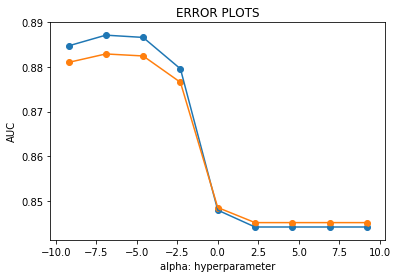

In [61]:
train_auc=[]
cv_auc=[]
import math
alpha=[10**-4,10**-3,10**-2,10**-1,10**0,10**1,10**2,10**3,10**4]
logalpha=[]
for i in alpha:
    clf=SGDClassifier(alpha=i,class_weight="balanced")
    clf.fit(tfidf_sent_vectors_train,Y_train)
    ccv=CalibratedClassifierCV(clf,cv="prefit")
    ccv.fit(tfidf_sent_vectors_cv,Y_cv)
    Y_train_pred =  ccv.predict_proba(tfidf_sent_vectors_train)[:,1]
    Y_cv_pred =  ccv.predict_proba(tfidf_sent_vectors_cv)[:,1]
    
    train_auc.append(roc_auc_score(Y_train,Y_train_pred))
    cv_auc.append(roc_auc_score(Y_cv, Y_cv_pred))
    
    logalpha.append(math.log(i))
    
plt.plot(logalpha, train_auc, label='Train AUC')
plt.scatter(logalpha, train_auc, label='Train AUC')
plt.plot(logalpha, cv_auc, label='CV AUC')
plt.scatter(logalpha, cv_auc, label='CV AUC')

plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

Optimal number alpha:  0.005


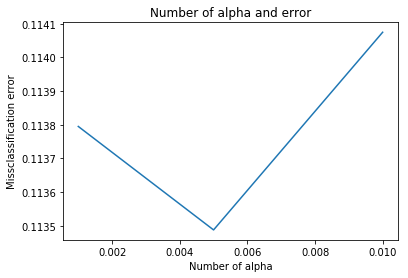

In [62]:
cv_score = []
alpha=[0.001,0.005,0.01]
for k in alpha:
    cvs = SGDClassifier(alpha=k,class_weight="balanced")
    scores = cross_val_score(cvs, tfidf_sent_vectors_train, Y_train, cv=10, scoring='roc_auc')
    cv_score.append(scores.mean())

# Miss classification error
MSE = [1-x for x in cv_score]
optimal_alpha4 = alpha[MSE.index(min(MSE))]
print("Optimal number alpha: ", optimal_alpha4)

plt.plot(alpha, MSE)
plt.title("Number of alpha and error")
plt.xlabel("Number of alpha")
plt.ylabel("Missclassification error")
plt.show()

In [0]:
model = SGDClassifier(alpha=optimal_alpha4,class_weight="balanced")
model.fit(tfidf_sent_vectors_train, Y_train)

optimal_model=CalibratedClassifierCV(model,cv="prefit")
optimal_model.fit(tfidf_sent_vectors_cv,Y_cv)
prediction = optimal_model.predict(tfidf_sent_vectors_test)

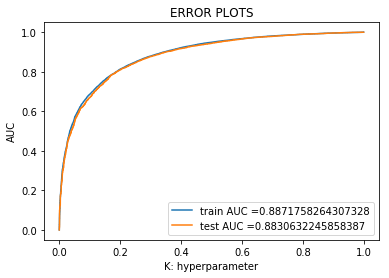

In [64]:
train_fpr, train_tpr, thresholds = roc_curve(Y_train, optimal_model.predict_proba(tfidf_sent_vectors_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, optimal_model.predict_proba(tfidf_sent_vectors_test)[:,1])
AUC4=str(auc(test_fpr, test_tpr))
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

confusion_matrix for train_data


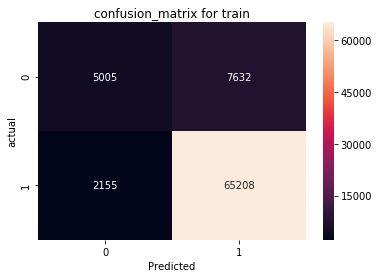

********************
confusion_matrix for test_data.


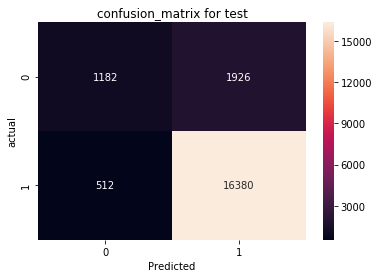

In [65]:
print("confusion_matrix for train_data")
conf_matrix = confusion_matrix(Y_train,optimal_model.predict(tfidf_sent_vectors_train))
class_label =[0,1]
df_conf_matrix = pd.DataFrame(conf_matrix,index=class_label,columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("confusion_matrix for train")
plt.xlabel("Predicted")
plt.ylabel('actual')
plt.show()
print("*"*20)

print("confusion_matrix for test_data.")
conf_matrix = confusion_matrix(Y_test,optimal_model.predict(tfidf_sent_vectors_test))
class_label =[0,1]
df_conf_matrix = pd.DataFrame(conf_matrix,index=class_label,columns=class_label)
sns.heatmap(df_conf_matrix,annot=True,fmt='d')
plt.title("confusion_matrix for test")
plt.xlabel("Predicted")
plt.ylabel('actual')
plt.show()

In [66]:
from sklearn.metrics import classification_report
print(classification_report(Y_test,prediction))

              precision    recall  f1-score   support

           0       0.70      0.38      0.49      3108
           1       0.89      0.97      0.93     16892

    accuracy                           0.88     20000
   macro avg       0.80      0.67      0.71     20000
weighted avg       0.86      0.88      0.86     20000



## [5.2] RBF SVM

### [5.2.1] Applying RBF SVM on BOW,<font color='red'> SET 1</font>

In [67]:
#obtaining the cleaned_text from the preprocessed_reviews  for the given dataset.
final['cleaned_text']=preprocessed_reviews

#Applying the time based splitting for the sample 15k datapts.
final.sort_values(by='Time')
final1 = final.sample(n = 10000)

Y = final1['Score'].values
X = final1['cleaned_text'].values
print(X.shape)
print(Y.shape)

(10000,)
(10000,)


In [68]:
# performing training,CV & testing for performing splitting of the dataset.
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,random_state=12,shuffle=False)
X_train,X_cv,Y_train,Y_cv=train_test_split(X,Y,test_size=0.2,random_state=12,shuffle=False)

print("After splitting the data")
print(X_train.shape,Y_train.shape)
print(X_cv.shape,Y_cv.shape)
print(X_test.shape,Y_test.shape)

After splitting the data
(8000,) (8000,)
(2000,) (2000,)
(2000,) (2000,)


In [69]:
vectorizer=CountVectorizer()
vectorizer=vectorizer.fit(X_train)

X_train_bow=vectorizer.transform(X_train)
X_cv_bow=vectorizer.transform(X_cv)
X_test_bow=vectorizer.transform(X_test)

print("After transforming the data")
print(X_train_bow.shape,Y_train.shape)
print(X_cv_bow.shape,Y_cv.shape)
print(X_test_bow.shape,Y_cv.shape)

After transforming the data
(8000, 18259) (8000,)
(2000, 18259) (2000,)
(2000, 18259) (2000,)


100%|██████████| 9/9 [21:56<00:00, 166.91s/it]


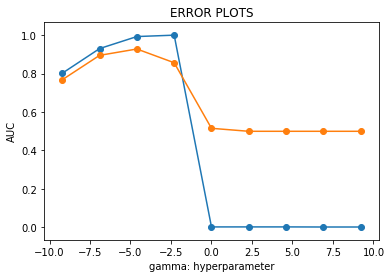

In [70]:
from sklearn.svm import SVC
loggamma=[]
train_auc=[]
cv_auc=[]
gamma=[10**-4,10**-3,10**-2,10**-1,10**0,10**1,10**2,10**3,10**4]
for i in tqdm(gamma):
    clf=SVC(gamma=i,probability=True,class_weight="balanced")
    clf.fit(X_train_bow,Y_train)
    Y_train_pred =  clf.predict_proba(X_train_bow)[:,1]
    Y_cv_pred =  clf.predict_proba(X_cv_bow)[:,1]
    
    train_auc.append(roc_auc_score(Y_train,Y_train_pred))
    cv_auc.append(roc_auc_score(Y_cv, Y_cv_pred))
    
    loggamma.append(math.log(i))
    
plt.plot(loggamma, train_auc, label='Train AUC')
plt.scatter(loggamma, train_auc, label='Train AUC')
plt.plot(loggamma, cv_auc, label='CV AUC')
plt.scatter(loggamma, cv_auc, label='CV AUC')

plt.xlabel("gamma: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

Optimal number gamma:  0.007


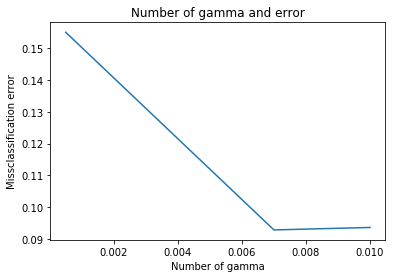

In [71]:

cv_score = []
gamma=[0.0005,0.007,0.01]
for k in gamma:
    cvs = SVC(gamma=k,probability=True,class_weight="balanced")
    scores = cross_val_score(cvs, X_train_bow, Y_train, cv=3, scoring='roc_auc')
    cv_score.append(scores.mean())
    
from sklearn.svm import SVC    
MSE = [1 - x for x in cv_score]
optimal_gamma_1 = gamma[MSE.index(min(MSE))]
print("Optimal number gamma: ", optimal_gamma_1)

plt.plot(gamma, MSE)
plt.title("Number of gamma and error")
plt.xlabel("Number of gamma")
plt.ylabel("Missclassification error")
plt.show()

In [0]:
optimal_model = SVC(gamma=optimal_gamma_1,probability=True,class_weight="balanced")
optimal_model.fit(X_train_bow, Y_train)
prediction = optimal_model.predict(X_test_bow)

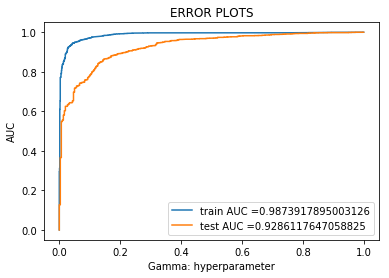

In [73]:
train_fpr, train_tpr, thresholds = roc_curve(Y_train, optimal_model.predict_proba(X_train_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, optimal_model.predict_proba(X_test_bow)[:,1])
AUC5=str(auc(test_fpr, test_tpr))
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("Gamma: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

confusion_matrix for train_data


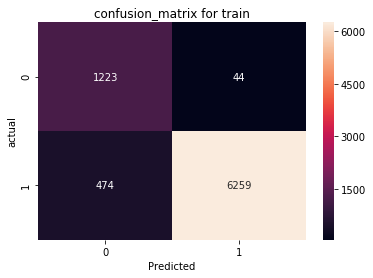

********************
confusion_matrix for test_data.


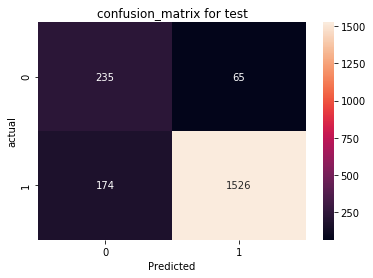

In [74]:
print("confusion_matrix for train_data")
conf_matrix = confusion_matrix(Y_train,optimal_model.predict(X_train_bow))
class_label =[0,1]
df_conf_matrix = pd.DataFrame(conf_matrix,index=class_label,columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("confusion_matrix for train")
plt.xlabel("Predicted")
plt.ylabel('actual')
plt.show()
print("*"*20)

print("confusion_matrix for test_data.")
conf_matrix = confusion_matrix(Y_test,optimal_model.predict(X_test_bow))
class_label =[0,1]
df_conf_matrix = pd.DataFrame(conf_matrix,index=class_label,columns=class_label)
sns.heatmap(df_conf_matrix,annot=True,fmt='d')
plt.title("confusion_matrix for test")
plt.xlabel("Predicted")
plt.ylabel('actual')
plt.show()

In [75]:
from sklearn.metrics import classification_report
print(classification_report(Y_test,prediction))

              precision    recall  f1-score   support

           0       0.57      0.78      0.66       300
           1       0.96      0.90      0.93      1700

    accuracy                           0.88      2000
   macro avg       0.77      0.84      0.80      2000
weighted avg       0.90      0.88      0.89      2000



### [5.2.2] Applying RBF SVM on TFIDF,<font color='red'> SET 2</font>

In [0]:
# Please write all the code with proper documentation

In [0]:
Tfidf_vect = TfidfVectorizer(ngram_range=(1,2),min_df = 10)
Tfidf_vect.fit(X_train)

Tfidf_train = Tfidf_vect.transform(X_train)
Tfidf_cv = Tfidf_vect.transform(X_cv)
Tfidf_test = Tfidf_vect.transform(X_test)

100%|██████████| 9/9 [21:18<00:00, 161.25s/it]


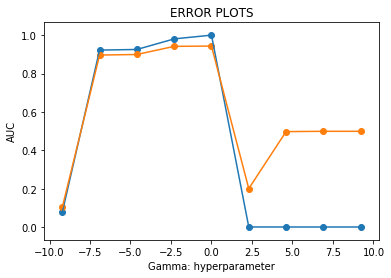

In [78]:
train_auc=[]
cv_auc=[]
import math
gamma=[10**-4,10**-3,10**-2,10**-1,10**0,10**1,10**2,10**3,10**4]
loggamma=[]
for i in tqdm(gamma):
    clf=SVC(gamma=i,probability=True,class_weight="balanced")
    clf.fit(Tfidf_train,Y_train)
    Y_train_pred =  clf.predict_proba(Tfidf_train)[:,1]
    Y_cv_pred =  clf.predict_proba(Tfidf_cv)[:,1]
    
    train_auc.append(roc_auc_score(Y_train,Y_train_pred))
    cv_auc.append(roc_auc_score(Y_cv, Y_cv_pred))
    
    loggamma.append(math.log(i))
    
plt.plot(loggamma, train_auc, label='Train AUC')
plt.scatter(loggamma, train_auc, label='Train AUC')
plt.plot(loggamma, cv_auc, label='CV AUC')
plt.scatter(loggamma, cv_auc, label='CV AUC')

plt.xlabel("Gamma: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

Optimal number gamma:  0.01


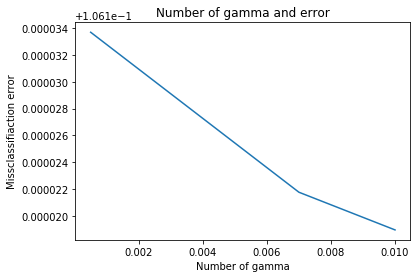

In [79]:

cv_score = []
gamma=[0.0005,0.007,0.01]
for k in gamma:
    cvs = SVC(gamma=k,probability=True,class_weight="balanced")
    scores = cross_val_score(cvs, Tfidf_train, Y_train, cv=3, scoring='roc_auc')
    cv_score.append(scores.mean())
    
from sklearn.svm import SVC    
MSE = [1 - x for x in cv_score]
optimal_gamma_2 = gamma[MSE.index(min(MSE))]
print("Optimal number gamma: ", optimal_gamma_2)

plt.plot(gamma, MSE)
plt.title("Number of gamma and error")
plt.xlabel("Number of gamma")
plt.ylabel("Missclassifiaction error")
plt.show()

In [0]:
optimal_model = SVC(gamma=optimal_gamma_2,probability=True,class_weight="balanced")
optimal_model.fit(Tfidf_train, Y_train)
prediction = optimal_model.predict(Tfidf_test)

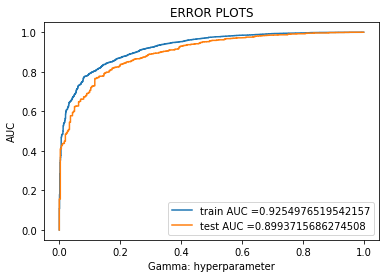

In [81]:
train_fpr, train_tpr, thresholds = roc_curve(Y_train, optimal_model.predict_proba(Tfidf_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, optimal_model.predict_proba(Tfidf_test)[:,1])
AUC6=str(auc(test_fpr, test_tpr))
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("Gamma: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

confusion_matrix for train_data


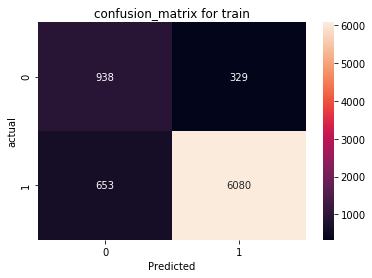

********************
confusion_matrix for test_data.


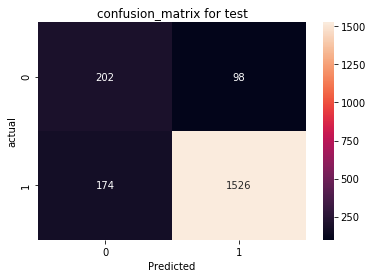

In [82]:
print("confusion_matrix for train_data")
conf_matrix = confusion_matrix(Y_train,optimal_model.predict(Tfidf_train))
class_label =[0,1]
df_conf_matrix = pd.DataFrame(conf_matrix,index=class_label,columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("confusion_matrix for train")
plt.xlabel("Predicted")
plt.ylabel('actual')
plt.show()
print("*"*20)

print("confusion_matrix for test_data.")
conf_matrix = confusion_matrix(Y_test,optimal_model.predict(Tfidf_test)) 
class_label =[0,1]
df_conf_matrix = pd.DataFrame(conf_matrix,index=class_label,columns=class_label)
sns.heatmap(df_conf_matrix,annot=True,fmt='d')
plt.title("confusion_matrix for test")
plt.xlabel("Predicted")
plt.ylabel('actual')
plt.show()

In [83]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, prediction))

              precision    recall  f1-score   support

           0       0.54      0.67      0.60       300
           1       0.94      0.90      0.92      1700

    accuracy                           0.86      2000
   macro avg       0.74      0.79      0.76      2000
weighted avg       0.88      0.86      0.87      2000



### [5.2.3]  Applying RBF SVM on AVG W2V,<font color='red'> SET 3</font>

In [84]:
i=0
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())

# this line of code trains your w2v model on the give list of sentances
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)

w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  5444
sample words  ['great', 'combination', 'sweet', 'salty', 'loved', 'addition', 'salt', 'bacon', 'product', 'arrived', 'usps', 'mail', 'good', 'condition', 'fresh', 'concentrate', 'sitting', 'store', 'shelf', 'long', 'time', 'syrup', 'turned', 'brown', 'instead', 'case', 'wondering', 'available', 'locally', 'san', 'francisco', 'asian', 'grocery', 'stores', 'safeway', 'supermarkets', 'cooking', 'think', 'local', 'distributor', 'no', 'longer', 'stocks', 'cannot', 'find', 'anywhere', 'last', 'years', 'bottle', 'smaller']


In [85]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sentance_train: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
sent_vectors_train = np.array(sent_vectors_train)
print(sent_vectors_train.shape)
print(sent_vectors_train[0])

(8000, 50)
[-0.52551343  0.57364013 -0.20971745  0.51525145  0.32190531 -0.09438849
 -0.97525711 -0.62247328  0.13992509 -0.63614833 -0.13175059  0.12203984
 -0.21193236 -0.24215339  0.35882427  0.3780167   0.5486762  -0.86972086
 -0.84856927 -0.51507519  0.65337558  0.69638353 -0.09725385 -0.38309612
  0.0932133   0.03482407 -0.35111676 -0.20928847 -0.10564233 -0.51703378
  0.51145833 -0.00835496  0.30021309  0.05150623  0.04686742 -0.0053446
  0.0970379  -0.18514578  0.33266222 -0.44630807  0.04536443  0.97103372
  0.65704741  0.23908182  0.84882326  0.17087047 -0.10910576  0.3152634
 -0.12269867  0.3337635 ]


In [86]:
i=0
list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sentance_cv: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
sent_vectors_cv = np.array(sent_vectors_cv)
print(sent_vectors_cv.shape)
print(sent_vectors_cv[0])

(2000, 50)
[-0.41170207  0.15484635 -0.0925068   0.77208766  0.24660287 -0.24425865
 -0.92946136 -0.40076668  0.1840239  -0.52262364 -0.25329723 -0.34262607
 -0.22627656 -0.13361774  0.62929149  0.49949615  0.59917238 -0.60011371
 -0.53765472 -0.19673954  0.56984813  0.66306286  0.10805834 -0.73490606
  0.08088635  0.05775672 -0.54684341 -0.14168325 -0.13850691 -0.49812158
  0.54749354  0.14930842  0.01766097 -0.08337281 -0.13120245  0.17755022
  0.14281289 -0.09791214  0.17523543 -0.35923661 -0.09481518  0.59497018
  0.15310727  0.00931201  0.74387487 -0.06384385  0.06332107  0.17527618
 -0.1197736   0.02968438]


In [87]:
i=0
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sentance_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
sent_vectors_test = np.array(sent_vectors_test)
print(sent_vectors_test.shape)
print(sent_vectors_test[0])

(2000, 50)
[-0.41170207  0.15484635 -0.0925068   0.77208766  0.24660287 -0.24425865
 -0.92946136 -0.40076668  0.1840239  -0.52262364 -0.25329723 -0.34262607
 -0.22627656 -0.13361774  0.62929149  0.49949615  0.59917238 -0.60011371
 -0.53765472 -0.19673954  0.56984813  0.66306286  0.10805834 -0.73490606
  0.08088635  0.05775672 -0.54684341 -0.14168325 -0.13850691 -0.49812158
  0.54749354  0.14930842  0.01766097 -0.08337281 -0.13120245  0.17755022
  0.14281289 -0.09791214  0.17523543 -0.35923661 -0.09481518  0.59497018
  0.15310727  0.00931201  0.74387487 -0.06384385  0.06332107  0.17527618
 -0.1197736   0.02968438]


100%|██████████| 9/9 [06:30<00:00, 47.46s/it]


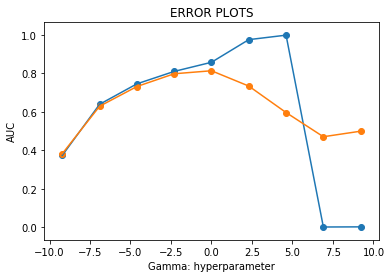

In [88]:
train_auc=[]
cv_auc=[]
import math
gamma=[10**-4,10**-3,10**-2,10**-1,10**0,10**1,10**2,10**3,10**4]
loggamma=[]
for i in tqdm(gamma):
    clf=SVC(gamma=i,probability=True,class_weight="balanced")
    clf.fit(sent_vectors_train,Y_train)
   
    Y_train_pred =  clf.predict_proba(sent_vectors_train)[:,1]
    Y_cv_pred =  clf.predict_proba(sent_vectors_cv)[:,1]
    
    train_auc.append(roc_auc_score(Y_train,Y_train_pred))
    cv_auc.append(roc_auc_score(Y_cv, Y_cv_pred))
    
    loggamma.append(math.log(i))
    
plt.plot(loggamma, train_auc, label='Train AUC')
plt.scatter(loggamma, train_auc, label='Train AUC')
plt.plot(loggamma, cv_auc, label='CV AUC')
plt.scatter(loggamma, cv_auc, label='CV AUC')

plt.xlabel("Gamma: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

Optimal number gamma:  0.01


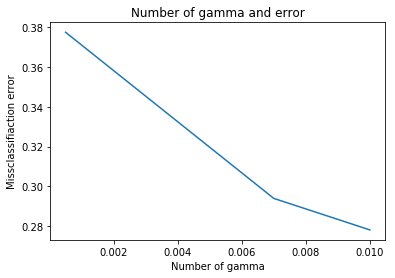

In [89]:

cv_score = []
gamma=[0.0005,0.007,0.01]
for k in gamma:
    cvs = SVC(gamma=k,probability=True,class_weight="balanced")
    scores = cross_val_score(cvs, sent_vectors_train, Y_train, cv=3, scoring='roc_auc')
    cv_score.append(scores.mean())
    
from sklearn.svm import SVC    
MSE = [1 - x for x in cv_score]
optimal_gamma_3 = gamma[MSE.index(min(MSE))]
print("Optimal number gamma: ", optimal_gamma_3)

plt.plot(gamma, MSE)
plt.title("Number of gamma and error")
plt.xlabel("Number of gamma")
plt.ylabel("Missclassifiaction error")
plt.show()

In [0]:
optimal_model = SVC(gamma=optimal_gamma_3,probability=True,class_weight="balanced")
optimal_model.fit(sent_vectors_train, Y_train)
prediction = optimal_model.predict(sent_vectors_test)

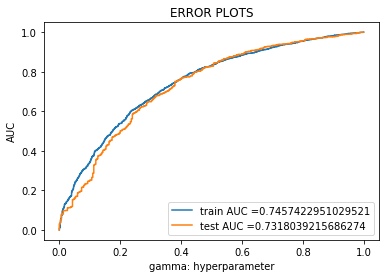

In [91]:
train_fpr, train_tpr, thresholds = roc_curve(Y_train, optimal_model.predict_proba(sent_vectors_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, optimal_model.predict_proba(sent_vectors_test)[:,1])
AUC7=str(auc(test_fpr, test_tpr))
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("gamma: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

confusion_matrix for train_data


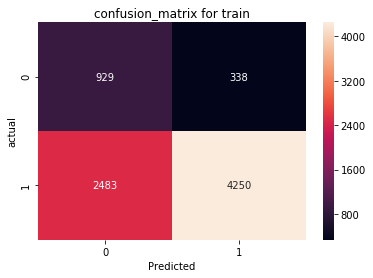

********************
confusion_matrix for test_data.


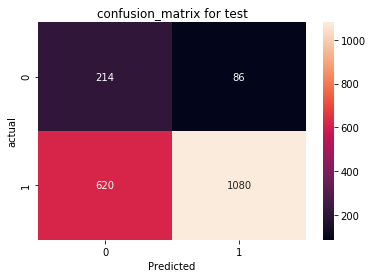

In [92]:
print("confusion_matrix for train_data")
conf_matrix = confusion_matrix(Y_train,optimal_model.predict(sent_vectors_train))
class_label =[0,1]
df_conf_matrix = pd.DataFrame(conf_matrix,index=class_label,columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("confusion_matrix for train")
plt.xlabel("Predicted")
plt.ylabel('actual')
plt.show()
print("*"*20)

print("confusion_matrix for test_data.")
conf_matrix = confusion_matrix(Y_test,optimal_model.predict(sent_vectors_test))
class_label =[0,1]
df_conf_matrix = pd.DataFrame(conf_matrix,index=class_label,columns=class_label)
sns.heatmap(df_conf_matrix,annot=True,fmt='d')
plt.title("confusion_matrix for test")
plt.xlabel("Predicted")
plt.ylabel('actual')
plt.show()

In [93]:
from sklearn.metrics import classification_report
print(classification_report(Y_test,prediction))

              precision    recall  f1-score   support

           0       0.26      0.71      0.38       300
           1       0.93      0.64      0.75      1700

    accuracy                           0.65      2000
   macro avg       0.59      0.67      0.57      2000
weighted avg       0.83      0.65      0.70      2000



### [5.2.4]  Applying RBF SVM on TFIDF W2V,<font color='red'> SET 4</font>

In [0]:
model = TfidfVectorizer()
Tfidf_matrix = model.fit(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [0]:
# TF-IDF weighted Word2Vec
i=0
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())
tfidf_feat = Tfidf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sentance_train: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

In [0]:
# TF-IDF weighted Word2Vec
i=0
list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())
tfidf_feat = Tfidf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sentance_cv: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1

In [0]:
# TF-IDF weighted Word2Vec
i=0
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())
tfidf_feat = Tfidf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sentance_test: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            #tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|██████████| 9/9 [06:37<00:00, 47.90s/it]


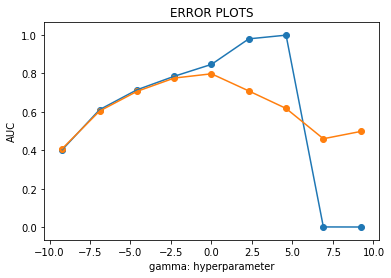

In [98]:
train_auc=[]
cv_auc=[]
import math
gamma=[10**-4,10**-3,10**-2,10**-1,10**0,10**1,10**2,10**3,10**4]
loggamma=[]
for i in tqdm(gamma):
    clf=SVC(gamma=i,probability=True,class_weight="balanced")
    clf.fit(tfidf_sent_vectors_train,Y_train)
    Y_train_pred =  clf.predict_proba(tfidf_sent_vectors_train)[:,1]
    Y_cv_pred =  clf.predict_proba(tfidf_sent_vectors_cv)[:,1]
    
    train_auc.append(roc_auc_score(Y_train,Y_train_pred))
    cv_auc.append(roc_auc_score(Y_cv, Y_cv_pred))
    
    loggamma.append(math.log(i))
    
plt.plot(loggamma, train_auc, label='Train AUC')
plt.scatter(loggamma, train_auc, label='Train AUC')
plt.plot(loggamma, cv_auc, label='CV AUC')
plt.scatter(loggamma, cv_auc, label='CV AUC')

plt.xlabel("gamma: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

Optimal number gamma:  0.01


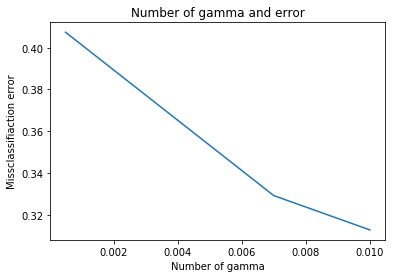

In [99]:

cv_score = []
gamma=[0.0005,0.007,0.01]
for k in gamma:
    cvs = SVC(gamma=k,probability=True,class_weight="balanced")
    scores = cross_val_score(cvs,tfidf_sent_vectors_train, Y_train, cv=3, scoring='roc_auc')
    cv_score.append(scores.mean())
    
from sklearn.svm import SVC    
MSE = [1 - x for x in cv_score]
optimal_gamma_4 = gamma[MSE.index(min(MSE))]
print("Optimal number gamma: ", optimal_gamma_4)

plt.plot(gamma, MSE)
plt.title("Number of gamma and error")
plt.xlabel("Number of gamma")
plt.ylabel("Missclassifiaction error")
plt.show()

In [0]:
optimal_model = SVC(gamma=optimal_gamma_4,probability=True,class_weight="balanced")
optimal_model.fit(tfidf_sent_vectors_train, Y_train)
prediction = optimal_model.predict(tfidf_sent_vectors_test)

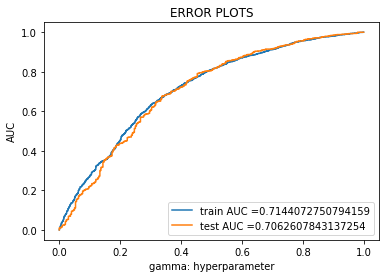

In [101]:
train_fpr, train_tpr, thresholds = roc_curve(Y_train, optimal_model.predict_proba(tfidf_sent_vectors_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, optimal_model.predict_proba(tfidf_sent_vectors_test)[:,1])
AUC8=str(auc(test_fpr, test_tpr))
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("gamma: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

confusion_matrix for train_data


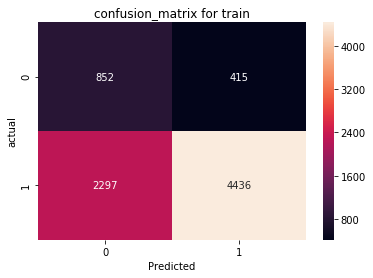

********************
confusion_matrix for test_data.


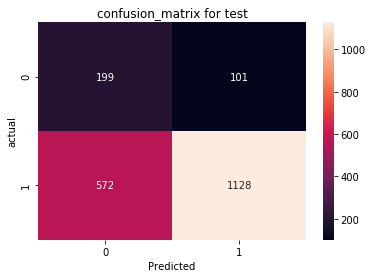

In [102]:
print("confusion_matrix for train_data")
conf_matrix = confusion_matrix(Y_train,optimal_model.predict(tfidf_sent_vectors_train))
class_label =[0,1]
df_conf_matrix = pd.DataFrame(conf_matrix,index=class_label,columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("confusion_matrix for train")
plt.xlabel("Predicted")
plt.ylabel('actual')
plt.show()
print("*"*20)

print("confusion_matrix for test_data.")
conf_matrix = confusion_matrix(Y_test,optimal_model.predict(tfidf_sent_vectors_test))
class_label =[0,1]
df_conf_matrix = pd.DataFrame(conf_matrix,index=class_label,columns=class_label)
sns.heatmap(df_conf_matrix,annot=True,fmt='d')
plt.title("confusion_matrix for test")
plt.xlabel("Predicted")
plt.ylabel('actual')
plt.show()

In [103]:
from sklearn.metrics import classification_report
print(classification_report(Y_test,prediction))

              precision    recall  f1-score   support

           0       0.26      0.66      0.37       300
           1       0.92      0.66      0.77      1700

    accuracy                           0.66      2000
   macro avg       0.59      0.66      0.57      2000
weighted avg       0.82      0.66      0.71      2000



In [0]:
## [5.3] Feature Engineering Model for Length of reviews using BOW.

In [0]:
######  In Feature Engineering model adding a length of reviews for feature to increasing the auc model.
#Creating a list af length of  the words from the preprocessed reviews

In [106]:
# Creating a list af length of  the words in preprocessed reviews
lengths=[]
for sentence in preprocessed_reviews:
    lengths.append(len(sentence.split()))
print(lengths[:5])
lengths1=np.asarray(lengths)
print(lengths1.shape)

[35, 27, 15, 53, 38]
(364171,)


In [107]:
#Taking 15kdatapoints for the length of reviews using bow.
final['lengths']=lengths1
final2 = final.sample(n = 10000)


X = final2['cleaned_text'].values
Y = final2['Score'].values
Z = final2['lengths'].values

print(X.shape)
print(Y.shape)
print(Z.shape)

(10000,)
(10000,)
(10000,)


In [108]:
#Similarly perfroming train,cv & test for length of the reviews concept
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,random_state=12,shuffle=False)
X_train,X_cv,Y_train,Y_cv=train_test_split(X,Y,test_size=0.2,random_state=12,shuffle=False)

print("After splitting the data.")
print(X_train.shape,  Y_train.shape)
print(X_cv.shape,     Y_cv.shape)
print(X_test.shape,   Y_test.shape)

After splitting the data.
(8000,) (8000,)
(2000,) (2000,)
(2000,) (2000,)


In [109]:
vectorizer=CountVectorizer()
vectorizer=vectorizer.fit(X_train)

X_train_bow=vectorizer.transform(X_train)
X_cv_bow=vectorizer.transform(X_cv)
X_test_bow=vectorizer.transform(X_test)

print("After transform")
print(X_train_bow.shape,  Y_train.shape)
print(X_cv_bow.shape,    Y_cv.shape)
print(X_test_bow.shape,   Y_test.shape)

After transform
(8000, 18143) (8000,)
(2000, 18143) (2000,)
(2000, 18143) (2000,)


In [110]:
A_train,A_test,B_train,B_test = train_test_split(Z,Y,test_size =0.2,random_state=12,shuffle=False)
A_train,A_cv,B_train,B_cv= train_test_split(Z,Y,test_size=0.2,random_state=12,shuffle= False)
print(A_train.shape,  B_train.shape)
print(A_cv.shape,    B_cv.shape)
print(A_test.shape,  B_test.shape)

(8000,) (8000,)
(2000,) (2000,)
(2000,) (2000,)


In [0]:
from scipy import sparse
from scipy.sparse import hstack

In [112]:
#Training model

print("Feature Engineering model for Train")

A_train1=sparse.csr_matrix(A_train)
print("X_train_bow:",X_train_bow.shape,type(X_train_bow))
print("A_train1:",A_train1.shape)

train = hstack([X_train_bow,A_train1.T]).toarray()
print(train)
##################################################################################################
print("*"*50)
print("Feature Engineering model for CV")

# Cross Validation model
A_cv1=sparse.csr_matrix(A_cv)
print("X_cv_bow:",X_cv_bow.shape)
print("A_cv1:",A_cv1.shape)
 
cv = hstack([X_cv_bow,A_cv1.T]).toarray()
print(cv)
###################################################################################################
print("*"*50)
print("Feature Engineering model for Test")

# Testing model.
A_test1=sparse.csr_matrix(A_test)

print("X_test_bow:",X_test_bow.shape)
print("A_test1:",A_test1.shape)
 
test = hstack([X_test_bow,A_test1.T]).toarray()
print(test)

Feature Engineering model for Train
X_train_bow: (8000, 18143) <class 'scipy.sparse.csr.csr_matrix'>
A_train1: (1, 8000)
[[  0   0   0 ...   0   0  32]
 [  0   0   0 ...   0   0  12]
 [  0   0   0 ...   0   0 153]
 ...
 [  0   0   0 ...   0   0  40]
 [  0   0   0 ...   0   0  13]
 [  0   0   0 ...   0   0  24]]
**************************************************
Feature Engineering model for CV
X_cv_bow: (2000, 18143)
A_cv1: (1, 2000)
[[ 0  0  0 ...  0  0 50]
 [ 0  0  0 ...  0  0 14]
 [ 0  0  0 ...  0  0 11]
 ...
 [ 0  0  0 ...  0  0  9]
 [ 0  0  0 ...  0  0 26]
 [ 0  0  0 ...  0  0 10]]
**************************************************
Feature Engineering model for Test
X_test_bow: (2000, 18143)
A_test1: (1, 2000)
[[ 0  0  0 ...  0  0 50]
 [ 0  0  0 ...  0  0 14]
 [ 0  0  0 ...  0  0 11]
 ...
 [ 0  0  0 ...  0  0  9]
 [ 0  0  0 ...  0  0 26]
 [ 0  0  0 ...  0  0 10]]


100%|██████████| 10/10 [02:03<00:00,  8.25s/it]


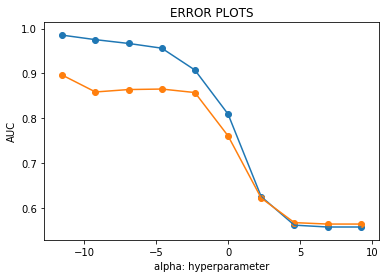

In [113]:
train_auc=[]
cv_auc=[]
import math
alpha=[10**-5,10**-4,10**-3,10**-2,10**-1,10**0,10**1,10**2,10**3,10**4]
logalpha=[]

for i in tqdm(alpha):
    clf=SGDClassifier(alpha=i,class_weight="balanced")
    clf.fit(train,Y_train)
    
    ccv=CalibratedClassifierCV(clf,cv="prefit")
    ccv.fit(cv,Y_cv)
    
    Y_train_pred =  ccv.predict_proba(train)[:,1]
    Y_cv_pred =  ccv.predict_proba(cv)[:,1]
    
    train_auc.append(roc_auc_score(Y_train,Y_train_pred))
    cv_auc.append(roc_auc_score(Y_cv, Y_cv_pred))
    
    logalpha.append(math.log(i))
    
plt.plot(logalpha, train_auc, label='Train AUC')
plt.scatter(logalpha, train_auc, label='Train AUC')
plt.plot(logalpha, cv_auc, label='CV AUC')
plt.scatter(logalpha, cv_auc, label='CV AUC')

plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

Optimal number alpha:  0.01


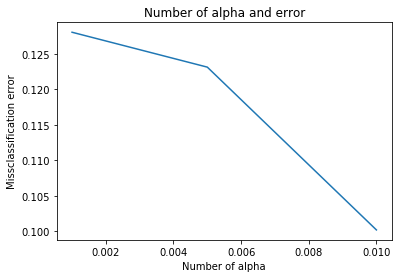

In [114]:
cv_score = []
alpha=[0.001,0.005,0.01]
for k in alpha:
    cvs = SGDClassifier(alpha=k,class_weight="balanced")
    scores = cross_val_score(cvs,train, Y_train, cv=10, scoring='roc_auc')
    cv_score.append(scores.mean())

# Miss classification error
MSE = [1-x for x in cv_score]
optimal_alpha = alpha[MSE.index(min(MSE))]
print("Optimal number alpha: ", optimal_alpha)

plt.plot(alpha, MSE)
plt.title("Number of alpha and error")
plt.xlabel("Number of alpha")
plt.ylabel("Missclassification error")
plt.show()

In [0]:
model = SGDClassifier(alpha=optimal_alpha,class_weight="balanced")
model.fit(train, Y_train)

optimal_model=CalibratedClassifierCV(model,cv="prefit")
optimal_model.fit(cv,Y_cv)
prediction = optimal_model.predict(test)

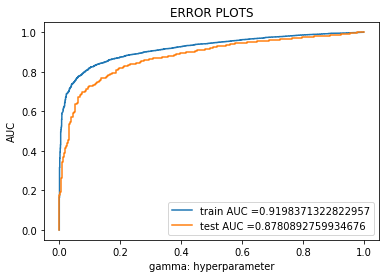

In [116]:
train_fpr, train_tpr, thresholds = roc_curve(Y_train, optimal_model.predict_proba(train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, optimal_model.predict_proba(test)[:,1])
AUC9=str(auc(test_fpr, test_tpr))
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("gamma: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

confusion_matrix for train_data


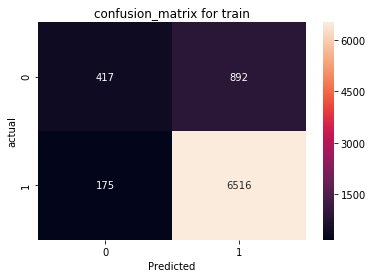

********************
confusion_matrix for test_data.


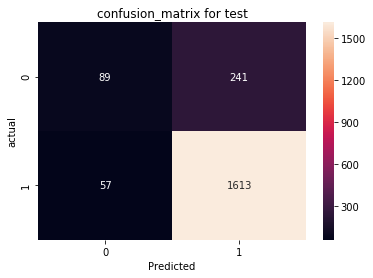

In [117]:
print("confusion_matrix for train_data")
conf_matrix = confusion_matrix(Y_train,optimal_model.predict(train))
class_label =[0,1]
df_conf_matrix = pd.DataFrame(conf_matrix,index=class_label,columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("confusion_matrix for train")
plt.xlabel("Predicted")
plt.ylabel('actual')
plt.show()
print("*"*20)

print("confusion_matrix for test_data.")
conf_matrix = confusion_matrix(Y_test,optimal_model.predict(test))
class_label =[0,1]
df_conf_matrix = pd.DataFrame(conf_matrix,index=class_label,columns=class_label)
sns.heatmap(df_conf_matrix,annot=True,fmt='d')
plt.title("confusion_matrix for test")
plt.xlabel("Predicted")
plt.ylabel('actual')
plt.show()


In [118]:
from sklearn.metrics import classification_report
print(classification_report(Y_test,prediction))

              precision    recall  f1-score   support

           0       0.61      0.27      0.37       330
           1       0.87      0.97      0.92      1670

    accuracy                           0.85      2000
   macro avg       0.74      0.62      0.64      2000
weighted avg       0.83      0.85      0.83      2000



# [6] Conclusions

#### The following steps for Linear SVM & RBF SVM

1.) USing 100k dataset points for Linear SVM & 10K data points for RBF SVM.

2.) Splitting the dataset in to train_data,CV_data & test_data.

3.) Applying Linear & RBF SVM both on BOW,TFIDF,AVG-W2V & TFIDF-W2V .

5.) Plotting (train)  for the ROC_AUC_curve for both the train & CV data.now,Applying the CV_score     for the given selected range.

6.)plotting MSE(MissClassificationError) to get optimal_alpha values for Linear SVM & also for the    RBF SVM.

7.) Taking an Optimal_model value so that it should not Overfit or Underfit.

8.)Plot(test) AUC_ROC_curve for train & test (tpr_fpr[TruePositiveRate & FalsePositiveRate]).
 
10.)Plotting confusion matrix for both Train & Test data.

11.)from all the above process obtaining the average classification report.



##>>>>> from the step 2 to step 8 all these steps are repeated simalarly for (BOW,TFIDF,AVG-    W2V,TFIDF-W2V) Using linear & RBF Kernel

1.)Similarly Applying the feature engineering model for the Length of review using BOW using 10k datapoints.(Same steps are followed for feature Engineering model also.)

In [134]:
from prettytable import PrettyTable
comparison = PrettyTable()

comparison.field_names = ["Vectorizer", "Kernel", "Alpha","Gamma", "AUC"]

comparison.add_row(["BOW",     "Linear SVM",      optimal_alpha1,'-',AUC1])
comparison.add_row(["TFIDF",    'Linear SVM',       optimal_alpha2,'-',AUC2])
comparison.add_row(["AVG-W2V",  'Linear SVM',     optimal_alpha2,'-',AUC3])
comparison.add_row(["TFIDF-W2V",'Linear SVM',    optimal_alpha2,'-',AUC4])

comparison.add_row(["BOW",     "RBF SVM",'-',   optimal_gamma_1,AUC5])
comparison.add_row(["TFIDF",   "RBF SVM",'-',  optimal_gamma_2,AUC6])
comparison.add_row(["AVG-W2V",  "RBF SVM",'-', optimal_gamma_3,AUC7])
comparison.add_row(["TFIDF-W2V","RBF SVM",'-', optimal_gamma_4,AUC8])

comparison.add_row(["Feature_Engineering(BOW)",'Linear',optimal_alpha,'-',AUC9])

print(comparison)


+--------------------------+------------+-------+-------+--------------------+
|        Vectorizer        |   Kernel   | Alpha | Gamma |        AUC         |
+--------------------------+------------+-------+-------+--------------------+
|           BOW            | Linear SVM | 0.001 |   -   | 0.9309158897573533 |
|          TFIDF           | Linear SVM | 0.001 |   -   | 0.5027644710578842 |
|         AVG-W2V          | Linear SVM | 0.001 |   -   | 0.9086831368088768 |
|        TFIDF-W2V         | Linear SVM | 0.001 |   -   | 0.8830632245858387 |
|           BOW            |  RBF SVM   |   -   | 0.007 | 0.9286117647058825 |
|          TFIDF           |  RBF SVM   |   -   |  0.01 | 0.8993715686274508 |
|         AVG-W2V          |  RBF SVM   |   -   |  0.01 | 0.7318039215686274 |
|        TFIDF-W2V         |  RBF SVM   |   -   |  0.01 | 0.7062607843137254 |
| Feature_Engineering(BOW) |   Linear   |  0.01 |   -   | 0.8780892759934676 |
+--------------------------+------------+-------+---